# Adjoint-based shape optimization of a waveguide bend

In this notebook, we will apply the adjoint method to the optimization of a low-loss waveguide bend. We start with a 90 degree bend in a SiN waveguide, parameterized using a `td.PolySlab`. 

We define an objective function that seeks to maximize the transmission of the TE0 output mode amplitude with respect to the position of the polygon vertices defining the bend. A penalty is applied to keep the local radii of curvature larger than a pre-defined value.

The resulting device demonstrates low loss and exhibits a smooth geometry.

> To install the `jax` module required for this feature, we recommend running `pip install "tidy3d[jax]"`.

If you are unfamiliar with inverse design, we also recommend our [intro to inverse design tutorials](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/) and our [primer on automatic differentiation with tidy3d](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin1Intro/).

## Setup

First, we import `tidy3d` and it's  `adjoint` plugin. We will also use `numpy`, `matplotlib` and `jax`. 

In [1]:
import tidy3d as td
import tidy3d.plugins.adjoint as tda
from tidy3d.plugins.adjoint.web import run_local as run

In [2]:
import numpy as np
import matplotlib.pylab as plt

In [3]:
import jax
import jax.numpy as jnp

Next, we define all the global parameters for our device and optimization.

In [4]:
wavelength = 1.5
freq0 = td.C_0 / wavelength

# frequency of measurement and source
# note: we only optimize results at the central frequency for now.
fwidth = freq0 / 10
num_freqs = 10
freqs = np.linspace(freq0 - fwidth/2, freq0 + fwidth/2, num_freqs)

# define the discretization of the bend polygon in angle
num_pts = 60
angles = np.linspace(0, np.pi/2, num_pts + 2)[1:-1]

# refractive indices of waveguide and substrate (air above)
n_wg = 2.0
n_sub = 1.5

# min space between waveguide and PML
spc = 1 * wavelength

# length of input and output straight waveguide sections
t = 1 * wavelength

# distance between PML and the mode source / mode monitor
mode_spc = t / 2.0

# height of waveguide core
h = 0.7

# minimum, starting, and maximum allowed thicknesses for the bend geometry
wmin = 0.5
wmid = 1.5
wmax = 2.5

# average radius of curvature of the bend
radius = 6

# minimum allowed radius of curvature of the polygon
min_radius = 150e-3

# name of the monitor measuring the transmission amplitudes for optimization
monitor_name = "mode"

# how many grid points per wavelength in the waveguide core material
min_steps_per_wvl = 30

# how many mode outputs to measure
num_modes = 3
mode_spec = td.ModeSpec(num_modes=num_modes)

Using all of these parameters, we can define the total simulation size.

In [5]:
Lx = Ly = t + radius + abs(wmax - wmid) + spc
Lz = spc + h + spc

### Define parameterization

Next we describe how the geometry looks as a function of our design parameters.

At each angle on our bend discretization, we define a parameter that can range between -inf and +inf to control the thickness of that section. If that parameter is -inf, 0, and +inf, the thickness of that section is `wmin`, `wmid`, and `wmax`, respectively.

This gives us a smooth way to constrain our measurable parameter without needing to worry about it in the optimization.

In [6]:
def thickness(param: float) -> float:
    """thickness of a bend section as a function of a parameter in (-inf, +inf)."""
    param_01 = (jnp.tanh(param) + 1.0) / 2.0
    return wmax * param_01 + wmin * (1 - param_01)

Next we write a function to generate all of our bend polygon vertices given our array of design parameters. Note that we add extra vertices at the beginning and end of the bend that are **independent** of the parameters (static) and are only there to make it easier to connect the bend to the input and output waveguide sections.

In [7]:
def make_vertices(params: np.ndarray) -> list:
    """Make bend polygon vertices as a function of design parameters."""
    vertices = []
    vertices.append((-Lx/2 + 1e-2, -Ly/2 + t + radius))
    vertices.append((-Lx/2 + t, -Ly/2 + t + radius + wmid/2))
    for angle, param in zip(angles, params):
        thickness_i = thickness(param)
        radius_i = radius + thickness_i/2.0
        x = radius_i * np.sin(angle) -Lx/2 + t
        y = radius_i * np.cos(angle) -Ly/2 + t
        vertices.append((x, y))
    vertices.append((-Lx/2 + t + radius + wmid/2, -Ly/2 + t))
    vertices.append((-Lx/2 + t + radius, -Ly/2 + 1e-2))
    vertices.append((-Lx/2 + t + radius - wmid/2, -Ly/2 + t))
    for angle, param in zip(angles[::-1], params[::-1]):
        thickness_i = thickness(param)
        radius_i = radius - thickness_i/2.0
        x = radius_i * np.sin(angle) -Lx/2 + t
        y = radius_i * np.cos(angle) -Ly/2 + t
        vertices.append((x, y))    
    vertices.append((-Lx/2 + t, -Ly/2 + t + radius - wmid/2))
    return vertices

Let's try out our `make_vertices` function on a set of all `0` parameters, which should give the starting waveguide width of `wmid` across the bend.

In [8]:
params = np.zeros(num_pts)
vertices = make_vertices(params)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


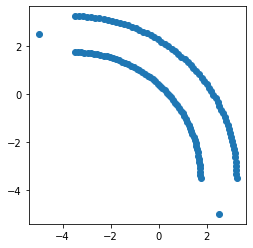

In [9]:
plt.scatter(*np.array(vertices).T)
ax = plt.gca()
ax.set_aspect("equal")

Looks good, note again that the extra points on the ends are just to ensure a solid overlap with the in and out waveguides. At this time, the adjoint plugin does not handle polygons that extend outside of the simulation domain so we need to also ensure that all points are inside of the domain.

Next we wrap this to write a function to generate a 3D [JaxPolySlab](../_autosummary/tidy3d.plugins.adjoint.JaxPolySlab.html) geometry given our design parameters. The `JaxPolySlab` is simply a jax-compatible version of the regular `PolySlab` geometry that can be differentiated through.

In [10]:
def make_polyslab(params: np.ndarray) -> tda.JaxPolySlab:
    """Make a `tidy3d.PolySlab` for the bend given the design parameters."""
    vertices = make_vertices(params)
    return tda.JaxPolySlab(
        vertices=vertices,
        slab_bounds=(-h/2, h/2),
        axis=2,
    )    

Let's visualize this as well.

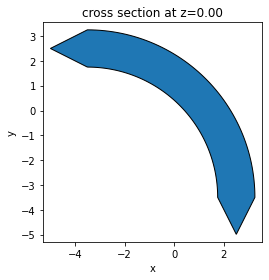

In [11]:
polyslab = make_polyslab(params)
ax = polyslab.plot(z=0)

Keeping with this theme, we add a function to generate a list of [JaxStructure](../_autosummary/tidy3d.plugins.adjoint.JaxStructure.html)s with just one element (our differentiable polygon bend). 

In [12]:
def make_input_structures(params) -> list[tda.JaxStructure]:
    polyslab = make_polyslab(params)
    medium = tda.JaxMedium(permittivity=n_wg**2)
    return [tda.JaxStructure(geometry=polyslab, medium=medium)]

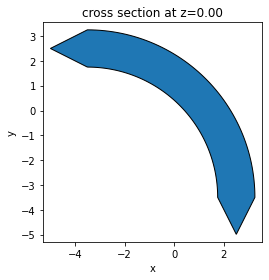

In [13]:
(ring,) = input_structures = make_input_structures(params)
ax = ring.plot(z=0)

Next, we define the other "static" geometries, such as the input waveguide section, output waveguide section, and substrate.

In [14]:
box_in = td.Box.from_bounds(
    rmin=(-Lx/2 - 1, -Ly/2 + t + radius - wmid/2, -h/2),
    rmax=(-Lx/2 + t + 1e-3, -Ly/2 + t + radius + wmid/2, +h/2),
)
box_out = td.Box.from_bounds(
    rmin=(-Lx/2 + t + radius - wmid/2, -Ly/2 - 1, -h/2),
    rmax=(-Lx/2 + t + radius + wmid/2, -Ly/2 + t, +h/2),
)

geo_sub = td.Box.from_bounds(
    rmin=(-td.inf, -td.inf, -10000),
    rmax=(+td.inf, +td.inf, -h/2),
)

wg_in = td.Structure(geometry=box_in, medium=td.Medium(permittivity=n_wg**2))
wg_out = td.Structure(geometry=box_out, medium=td.Medium(permittivity=n_wg**2))
substrate = td.Structure(geometry=geo_sub, medium=td.Medium(permittivity=n_sub**2))

## Fabrication Constraints

With the current parameterization, it is possible to generate structures with wildly varying radii of curvature which may be difficult to fabricate. To alleviate this, we introduce a minimum radius of curvature penalty transformation using the tidy3d adjoint utilities. The penalty will take a set of vertices, compute the local radius of curvature using a quadratic Bezier curve, and return an average penalty function that depends on how much smaller the local radii are compared to a desired minimum radius.

In [15]:
from tidy3d.plugins.adjoint.utils.penalty import RadiusPenalty

penalty = RadiusPenalty(min_radius=min_radius, alpha=1.0, kappa=10.0)

We then wrap this penalty to look at only the inner and outer vertices independently and average the penalty from each.

In [16]:
def eval_penalty(params):
    """Evaluate penalty on a set of params looking at radius of curvature."""
    vertices = make_vertices(params)
    _vertices =  jnp.array(vertices)
    vertices_top = _vertices[1:num_pts+3] # select outer set of points along bend
    vertices_bot = _vertices[num_pts+4:]  # select inner set of points along bend
    penalty_top = penalty.evaluate(vertices_top)
    penalty_bot = penalty.evaluate(vertices_bot)
    return (penalty_top + penalty_bot) / 2.0

Let's try this out on our starting parameters. We see we get a jax traced float that seems reasonably low given our smooth starting structure.

In [17]:
eval_penalty(params)

Array(3.5788543e-23, dtype=float32)

## Define Simulation

Now we define our sources, monitors, and simulation.

We first define a mode source injected at the input waveguide.

In [18]:
mode_width = wmid + 2 * spc
mode_height = Lz

mode_src = td.ModeSource(
    size=(0, mode_width, mode_height),
    center=(-Lx/2 + t/2, -Ly/2 + t + radius, 0),
    direction="+",
    source_time=td.GaussianPulse(
        freq0=freq0,
        fwidth=fwidth,
    )
)

Next, we define monitors for storing:

- The output mode amplitude at the central frequency.

- The flux on the output plane (for reference).

- The output mode amplitude across a frequency range (for examining the transmission spectrum of our final device).

- A field monitor to measure fields directly in the z-normal plane intersecting the waveguide.

In [19]:
mode_mnt = td.ModeMonitor(
    size=(mode_width, 0, mode_height),
    center=(-Lx/2 + t + radius, -Ly/2 + t/2, 0),
    name=monitor_name,
    freqs=[freq0],
    mode_spec=mode_spec,
)

flux_mnt = td.FluxMonitor(
    size=(mode_width, 0, mode_height),
    center=(-Lx/2 + t + radius, -Ly/2 + t/2, 0),
    name="flux",
    freqs=[freq0],
)

mode_mnt_bb = td.ModeMonitor(
    size=(mode_width, 0, mode_height),
    center=(-Lx/2 + t + radius, -Ly/2 + t/2, 0),
    name="mode_bb",
    freqs=freqs.tolist(),
    mode_spec=mode_spec,
)

fld_mnt = td.FieldMonitor(
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name="field",
)

[22:01:59] WARNING: Default value for the field monitor           ]8;id=619960;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=943858;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

Next we put everything together into a function that returns a [JaxSimulation](../_autosummary/tidy3d.plugins.adjoint.JaxSimulation.html) given our parameters and an optional boolean specifying whether to include the field monitor (to save data when fields are not required).

In [20]:
def make_sim(params, use_fld_mnt: bool = True) -> tda.JaxSimulation:
    monitors = [mode_mnt_bb, flux_mnt]
    if use_fld_mnt:
        monitors += [fld_mnt]
    input_structures = make_input_structures(params)
    return tda.JaxSimulation(
        size=(Lx, Ly, Lz),
        input_structures=input_structures,
        structures=[substrate, wg_in, wg_out],
        sources=[mode_src],
        output_monitors=[mode_mnt],
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl),
        boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=True),
        monitors=monitors,
        run_time = 10/fwidth,
)

Let's try it out and plot our simulation.

           WARNING: 'JaxPolySlab'-containing                   ]8;id=327486;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/plugins/adjoint/components/simulation.py\simulation.py]8;;\:]8;id=628199;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/plugins/adjoint/components/simulation.py#202\202]8;;\
           'JaxSimulation.input_structures[0]' intersects with                  
           'JaxSimulation.structures[1]'. Note that in this                     
           version of the adjoint plugin, there may be errors                   
           in the gradient when 'JaxPolySlab' intersects with                   
           background structures.                                               

           WARNING: Suppressed 1 WARNING message.                     ]8;id=767253;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/log.py\log.py]8;;\:]8;id=469873;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/log.py#130\130]8;;\

           WARNING: Structure at structures[3] was detected as ]8;id=205479;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=745382;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#486\486]8;;\
           being less than half of a central wavelength from a                  
           PML on side x-min. To avoid inaccurate results,                      
           please increase gap between any structures and PML                   
           or fully extend structure through the pml.                           

           WARNING: Suppressed 1 WARNING message.                     ]8;id=687173;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/log.py\log.py]8;;\:]8;id=636589;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/log.py#130\130]8;;\

           WARNING: Structure at structures[3] was detected as ]8;id=853187;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=646422;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#486\486]8;;\
           being less than half of a central wavelength from a                  
           PML on side x-min. To avoid inaccurate results,                      
           please increase gap between any structures and PML                   
           or fully extend structure through the pml.                           

           WARNING: Suppressed 1 WARNING message.                     ]8;id=336518;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/log.py\log.py]8;;\:]8;id=907253;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/log.py#130\130]8;;\

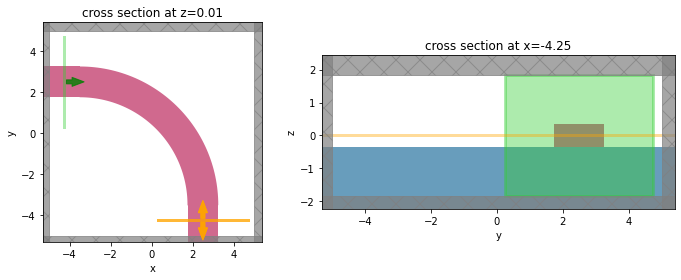

In [21]:
sim = make_sim(params)

f, (ax1, ax2) = plt.subplots(1,2,tight_layout=True, figsize=(10,4))
ax = sim.plot(z=0.01, ax=ax1)
ax = sim.plot(x=-Lx/2+t/2, ax=ax2)

> Note: we get warnings from the adjoint plugin because the polyslab intersects the static waveguide ports and those edges will give inaccurate gradients. We can safely ignore those warnings because we don't need gradients with respect to them.

In [22]:
td.config.logging_level = "ERROR"

## Select the desired waveguide mode

Next, we use the [ModeSolver](../_autosummary/tidy3d.plugins.mode.ModeSolver.html) to solve and select the `mode_index` that gives us the proper injected and measured modes. We plot all of the fields for the first 3 modes and see that the TE0 mode is `mode_index=0`.

Effective index of computed modes:  [[1.7966835 1.7514163 1.6002883]]


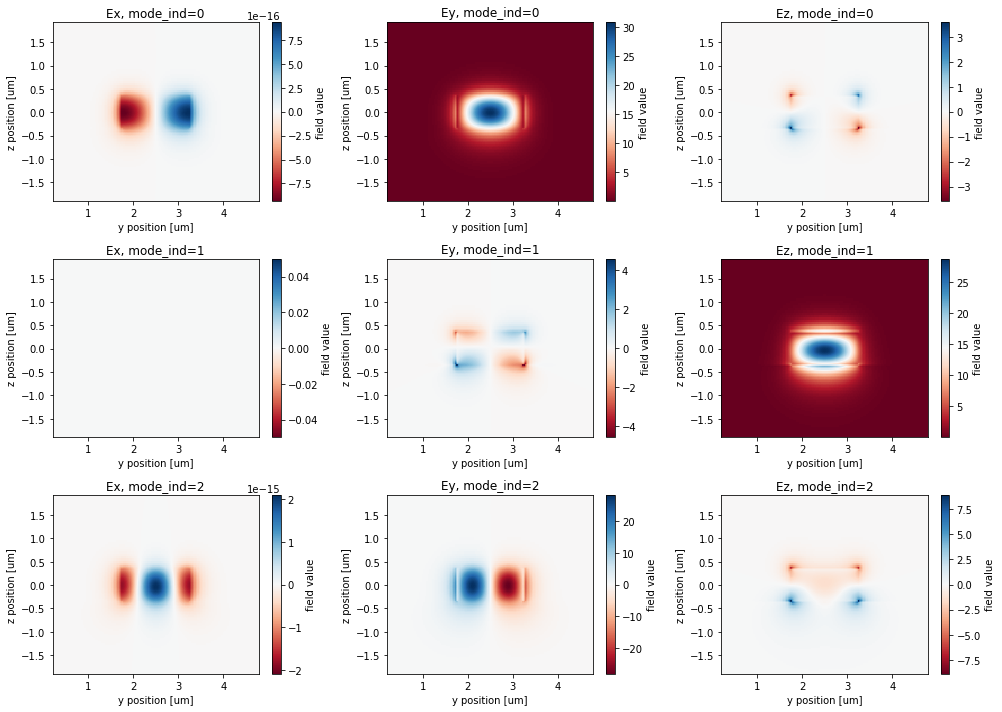

In [23]:
from tidy3d.plugins.mode import ModeSolver

ms = ModeSolver(simulation=sim, plane=mode_src, mode_spec=mode_spec, freqs=mode_mnt.freqs)
data = ms.solve()

print("Effective index of computed modes: ", np.array(data.n_eff))

fig, axs = plt.subplots(num_modes, 3, figsize=(14, 10), tight_layout=True)
for mode_ind in range(num_modes):
    for field_ind, field_name in enumerate(("Ex", "Ey", "Ez")):
        field = data.field_components[field_name].sel(mode_index=mode_ind)
        ax = axs[mode_ind, field_ind]
        field.real.plot(x='y', y='z', ax=ax, cmap='RdBu')
        ax.set_title(f"{field_name}, mode_ind={mode_ind}")

Since this is already the default mode index, we can leave the original `make_sim()` function as is. However, to generate a new mode source with a different `mode_index`, we could do the following and rewrite that function with the returned `mode_src`.

In [24]:
# select the mode index
mode_index = 0

# make the mode source with appropriate mode index
mode_src = ms.to_source(mode_index=mode_index, source_time=mode_src.source_time, direction=mode_src.direction)

## Defining objective function

Now we can define our objective function to maximize. The objective function first generates a simulation given the parameters, runs the simulation using the `jax`-compatible [tidy3d.plugins.adjoint.run](../_autosummary/tidy3d.plugins.adjoint.web.run.html) function, measures the power transmitted into the TE0 output mode at our desired polarization, and then subtracts the radius of curvature penalty that we defined earlier.

For convenience, we also return the [JaxSimulationData](../_autosummary/tidy3d.plugins.adjoint.JaxSimulationData.html) as the 2nd output, which will be ignored by `jax` when we pass `has_aux=True` when computing the gradient of this function.

In [25]:
def objective(params, use_fld_mnt:bool = True):
    sim = make_sim(params, use_fld_mnt=use_fld_mnt)
    sim_data = run(sim, task_name='bend', verbose=False)
    amps = sim_data[monitor_name].amps.sel(direction="-", mode_index=mode_index).values
    transmission = jnp.abs(jnp.array(amps))**2
    J = jnp.sum(transmission) - eval_penalty(params)
    return J, sim_data

Next, we use [jax.value_and_grad](https://jax.readthedocs.io/en/latest/_autosummary/jax.value_and_grad.html) to transform this objective function into a function that returns the 

* Objective function evaluated at the passed parameters.

* Auxilary [JaxSimulationData](../_autosummary/tidy3d.plugins.adjoint.JaxSimulationData.html) corresponding to the forward pass (for plotting later).

* Gradient of the objective function with respect to the passed parameters.

In [26]:
val_grad = jax.value_and_grad(objective, has_aux=True)

Let's run this function and take a look at the outputs.

In [27]:
(val, sim_data), grad = val_grad(params)

In [28]:
print(val)
print(grad)

0.5606048
[-0.01883917 -0.02968327 -0.04119704 -0.05332555 -0.0657288  -0.07819955
 -0.09031129 -0.10045863 -0.11044198 -0.11628526 -0.11940013 -0.11855873
 -0.11367789 -0.10428579 -0.09043597 -0.07393086 -0.05485675 -0.03374749
 -0.01146651  0.01097884  0.03232303  0.0521329   0.07017162  0.08563211
  0.09907499  0.10945182  0.11626573  0.12678576  0.11849307  0.12726338
  0.12726587  0.11850015  0.12679777  0.11628053  0.10946865  0.0990923
  0.08564843  0.07018599  0.05214434  0.03233124  0.01098366 -0.01146469
 -0.03374784 -0.0548588  -0.07393336 -0.09043836 -0.10428729 -0.11367796
 -0.11855777 -0.11939806 -0.11628282 -0.11043957 -0.10045616 -0.09030911
 -0.07819756 -0.06572723 -0.05332468 -0.04119653 -0.02968323 -0.01883924]


These seem reasonable and can now be used for plugging into our optimization algorithm.

## Optimization Procedure

With our gradients defined, we write a simple optimization loop using the [optax](https://optax.readthedocs.io/en/latest/) package. We use the `adam` method with a tunable number of steps and learning rate. The intermediate values, parameters, and data are stored for visualization later.

> Note: this will take several minutes. While not shown here, it is good practice to checkpoint your optimization results by saving to file on every iteration, or ensure you have a stable internet connection. See [this notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin6GratingCoupler/) for more details. 

In [29]:
import optax

# hyperparameters
num_steps = 40
learning_rate = 0.1

# initialize adam optimizer with starting parameters
params = np.array(params).copy()
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
objective_history = []
param_history = [params]
data_history = []

for i in range(num_steps):

    # compute gradient and current objective funciton value
    (value, sim_data), gradient = val_grad(params)
    
    # multiply all by -1 to maximize obj_fn
    gradient = -np.array(gradient.copy())

    # outputs
    print(f"step = {i + 1}")
    print(f"\tJ = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")    

    # compute and apply updates to the optimizer based on gradient
    updates, opt_state = optimizer.update(gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    # save history
    objective_history.append(value)
    param_history.append(params)
    data_history.append(sim_data)


step = 1
	J = 5.6060e-01
	grad_norm = 6.7526e-01
step = 2
	J = 8.4790e-01
	grad_norm = 4.8040e-01
step = 3
	J = 8.9985e-01
	grad_norm = 4.0505e-01
step = 4
	J = 8.5131e-01
	grad_norm = 5.0348e-01
step = 5
	J = 8.3506e-01
	grad_norm = 4.8749e-01
step = 6
	J = 8.6678e-01
	grad_norm = 4.8803e-01
step = 7
	J = 9.2224e-01
	grad_norm = 3.5351e-01
step = 8
	J = 9.5242e-01
	grad_norm = 1.8946e-01
step = 9
	J = 9.4218e-01
	grad_norm = 2.4269e-01
step = 10
	J = 9.1947e-01
	grad_norm = 2.9453e-01
step = 11
	J = 9.0531e-01
	grad_norm = 3.2005e-01
step = 12
	J = 9.1071e-01
	grad_norm = 3.1154e-01
step = 13
	J = 9.3085e-01
	grad_norm = 2.5689e-01
step = 14
	J = 9.5300e-01
	grad_norm = 1.7606e-01
step = 15
	J = 9.6490e-01
	grad_norm = 1.0440e-01
step = 16
	J = 9.6218e-01
	grad_norm = 1.3483e-01
step = 17
	J = 9.5238e-01
	grad_norm = 1.9516e-01
step = 18
	J = 9.4548e-01
	grad_norm = 2.2601e-01
step = 19
	J = 9.4680e-01
	grad_norm = 2.1709e-01
step = 20
	J = 9.5441e-01
	grad_norm = 1.7686e-01
step = 21

## Analyzing results

After the optimization is finished, let's look at the results.

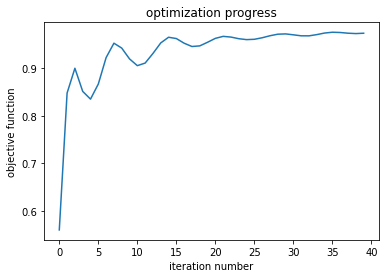

In [30]:
_ = plt.plot(objective_history)
ax = plt.gca()
ax.set_xlabel('iteration number')
ax.set_ylabel('objective function')
ax.set_title('optimization progress')
plt.show()

Next, we can grab our initial and final device from the history lists.

In [31]:
sim_start = make_sim(param_history[0])
data_start = data_history[0]

sim_final = make_sim(param_history[-1])
data_final = data_history[-1]


Let's take a look at the final structure. We see that it has a smooth design which is symmetric about the 45 degree angle.

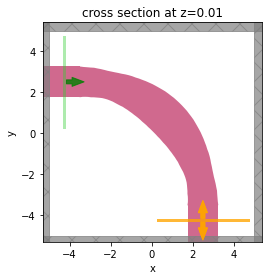

In [32]:
ax = sim_final.plot(z=0.01)

Now let's inspect the difference between the initial and final intensity patterns. We notice that the final device is quite effective at coupling light into the output waveguide! This is especially evident when compared to the starting device.

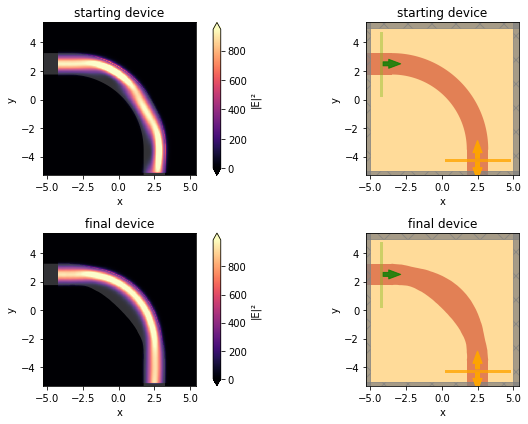

In [33]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, tight_layout=True, figsize=(10, 6))

_ = data_start.plot_field('field', 'E', 'abs^2', ax=ax1)
_ = sim_start.plot(z=0, ax=ax2)
ax1.set_title('starting device')
ax2.set_title('starting device')

_ = data_final.plot_field('field', 'E', 'abs^2', ax=ax3)
_ = sim_final.plot(z=0, ax=ax4)
ax3.set_title('final device')
ax4.set_title('final device')

plt.show()

Let's view the transmission now, both in linear and dB scale.

The mode amplitudes are simply an [xarray.DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html) that can be selected, post processed, and plotted.

In [34]:
amps = sim_data['mode_bb'].amps.sel(direction="-", mode_index=mode_index)

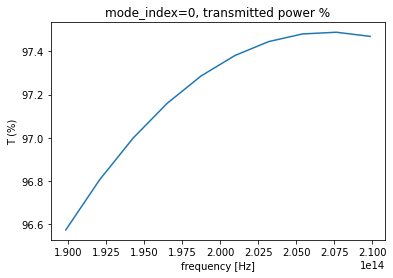

In [35]:
transmission = abs(amps)**2 
transmission_percent = 100 * transmission
transmission_percent.plot(x="f")
ax = plt.gca()
ax.set_title('mode_index=0, transmitted power %')
ax.set_ylabel('T (%)')
plt.show()

We can also put this in log scale.

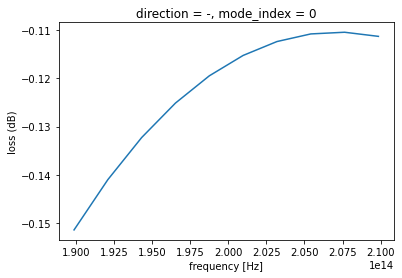

In [36]:
loss = 1 - transmission
loss_db = 10 * np.log10(transmission)
loss_db.plot(x="f")
plt.ylabel('loss (dB)')
plt.show()

Finally, let's animate the field pattern evolution over the entire optimization. This will take a minute or so.

In [37]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=False, figsize=(8, 4))

def animate(i):

    # grab data at iteration "i"
    sim_data_i = data_history[i]

    # plot permittivity
    sim_i = sim_data_i.simulation.to_simulation()[0]
    sim_i.plot_eps(z=0, monitor_alpha=0.0, source_alpha=0.0, ax=ax1)
    # ax1.set_aspect('equal')
    
    # plot intensity
    int_i = sim_data_i.get_intensity("field")
    int_i.squeeze().plot.pcolormesh(x='x', y='y', ax=ax2, add_colorbar=False, cmap="magma")
    # ax2.set_aspect('equal')
    
# create animation
ani = animation.FuncAnimation(fig, animate, frames=len(data_history));
plt.close()

# display the animation (press "play" to start)
HTML(ani.to_jshtml())


<Figure size 432x288 with 0 Axes>

> To save the animation to file, uncomment the line below. Will take a few minutes to render.

In [39]:
# ani.save('animation_bend_adjoint.gif', fps=60)

MovieWriter ffmpeg unavailable; using Pillow instead.


<Figure size 432x288 with 0 Axes>